In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from tqdm import tqdm
from IPython.display import clear_output
from collections import deque

In [2]:
env = gym.make('CartPole-v1')

state_shape = env.observation_space.shape[0]
no_of_actions = env.action_space.n

In [3]:
#discretize the spaces
discrete_factor = 50
theta_discrete = np.linspace(-0.20943951, 0.20943951, discrete_factor)
theta_dot_discrete = np.linspace(-2.0, 2.0, discrete_factor//5)
pose_discrete = np.linspace(-2.4, 2.4, discrete_factor)
vel_discrete = np.linspace(-2.0 ,2.0, discrete_factor//5)

def cont_to_discrete(state):
    cartX, cartXdot, cartTheta, cartThetadot = state
    cartX = int(np.digitize(cartX, pose_discrete))
    cartXdot = int(np.digitize(cartXdot, vel_discrete ))
    cartTheta = int(np.digitize(cartTheta, theta_discrete))
    cartThetadot = int(np.digitize(cartThetadot, theta_dot_discrete))

    return (cartX, cartXdot, cartTheta, cartThetadot)


In [4]:
from scipy.special import softmax
def choose_action_softmax(Q, state, tau):
    return np.random.choice(Q.shape[-1], p = softmax(Q[state]/tau))

In [5]:
def q_learning(Q, env, max_episodes, max_t, gamma, alpha, tau):
    rewards = np.zeros(max_episodes)
    #Store mean of last 100 scores
    last_100_mean = 0

    for episode in range(1, max_episodes+1):
        state, _ = env.reset()
        state = cont_to_discrete(state)
        score = 0
        for t in range(max_t):
            action = choose_action_softmax(Q, state, tau)
            next_state, reward, done, _ , _ = env.step(action)
            next_state = cont_to_discrete(next_state)
            Q[state + (action,)] += alpha * (reward + gamma * np.max(Q[next_state]) - Q[state + (action,)])
            state = next_state
            score += reward
            if done:
                break

        rewards[episode-1] = score

        if episode == 1:
            last_100_mean = score
        elif episode <= 100:
            last_100_mean = (last_100_mean * (episode-1) + score) / episode
        else:
            last_100_mean += (score - rewards[episode-100]) / 100

        #tau = max(tau_min, tau_decay*tau)

        print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode, last_100_mean), end="")

        #if episode % 5000 == 0:
        #print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode, last_100_mean))
        if last_100_mean>475.0:
           print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(episode, last_100_mean))
           rewards[episode:] = 475.0
           return rewards
    return rewards

In [8]:
max_episodes=25000
max_t=1000
gamma = 0.99
alpha = 0.1
tau_values = [8, 4, 2, 1, 0.5]
rewards = dict()
regrets = dict()
for tau in tau_values:
    print("\ntau = ", tau)
    reward_sum = np.zeros(max_episodes)
    for i in range(5):
        print("\nRun: ", i+1)
        Q = np.random.uniform(low=0, high=1, size=[discrete_factor+1, (discrete_factor)//5 + 1, discrete_factor+1, (discrete_factor)//5 + 1] + [no_of_actions])
        reward_sum += q_learning(Q, env, max_episodes, max_t, gamma, alpha, tau)
    rewards[tau] = reward_sum/5

    total_regret = 475*len(rewards[tau]) - np.sum(rewards[tau])
    regrets[tau] = total_regret
    print('\nTotal regret for tau = {} : {}'.format(tau, total_regret))


tau =  8

Run:  1
Episode 25000	Average Score: 61.93
Run:  2
Episode 25000	Average Score: 68.84
Run:  3
Episode 25000	Average Score: 64.25
Run:  4
Episode 25000	Average Score: 62.94
Run:  5
Episode 25000	Average Score: 64.53
Total regret for tau = 8 : 10628142.2

tau =  4

Run:  1
Episode 25000	Average Score: 298.73
Run:  2
Episode 25000	Average Score: 281.37
Run:  3
Episode 25000	Average Score: 337.02
Run:  4
Episode 25000	Average Score: 383.90
Run:  5
Episode 25000	Average Score: 346.00
Total regret for tau = 4 : 6658264.800000001

tau =  2

Run:  1
Episode 25000	Average Score: 203.29
Run:  2
Episode 25000	Average Score: 235.20
Run:  3
Episode 25000	Average Score: 161.89
Run:  4
Episode 25000	Average Score: 239.85
Run:  5
Episode 25000	Average Score: 422.90
Total regret for tau = 2 : 7085880.8

tau =  1

Run:  1
Episode 25000	Average Score: 284.37
Run:  2
Episode 25000	Average Score: 134.32
Run:  3
Episode 25000	Average Score: 136.50
Run:  4
Episode 25000	Average Score: 168.76
Run: 

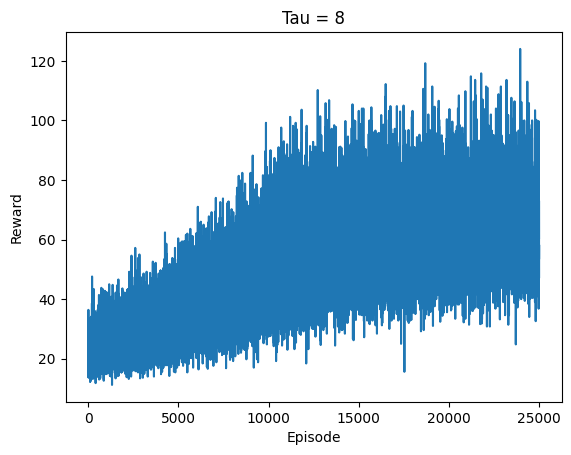

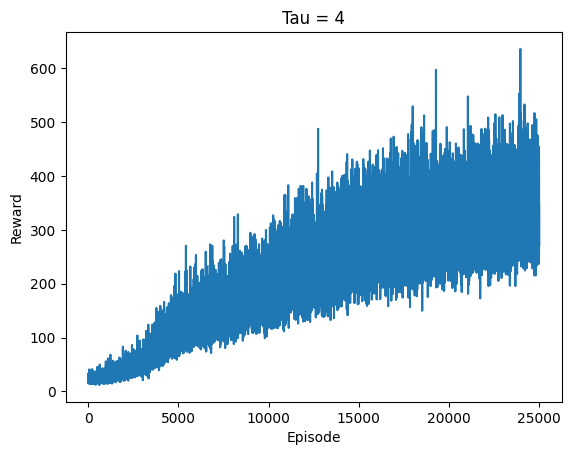

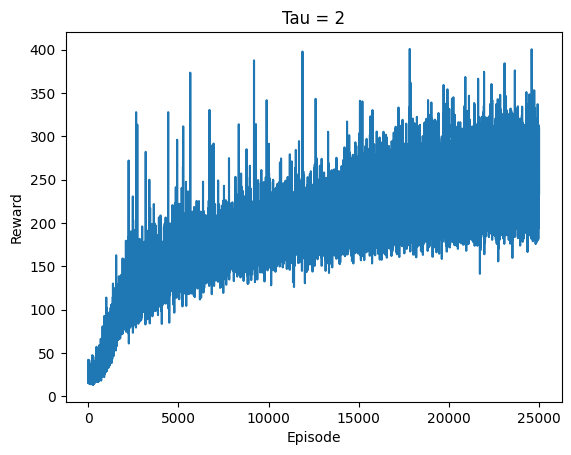

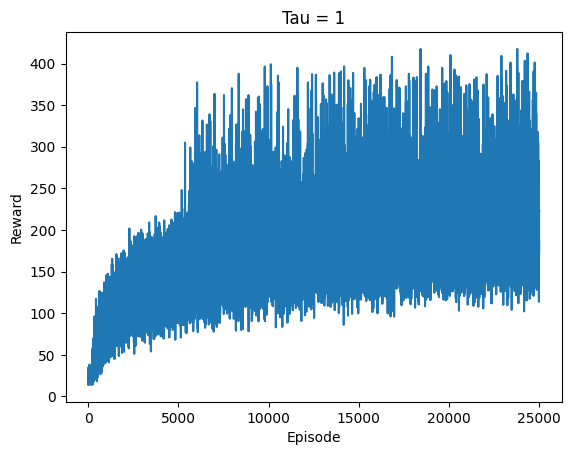

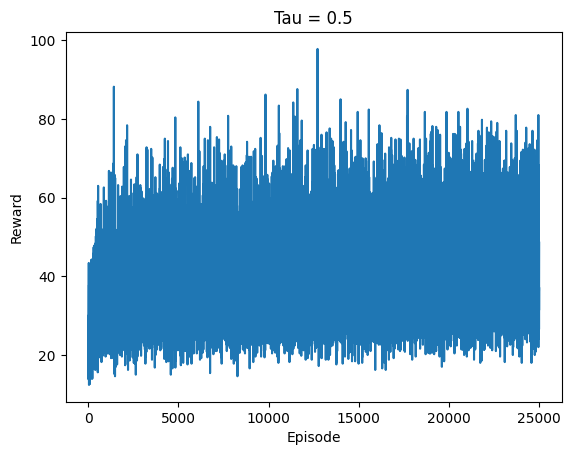

In [9]:
for tau in tau_values:
    plt.plot(range(1, len(rewards[tau])+1), rewards[tau])
    plt.title('Tau = ' + str(tau))
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.show()

In [12]:
def moving_average(a, n):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    ret[n:] = ret[n:] / n
    ret[:n] = ret[:n]/np.arange(1, n+1, 1)
    return ret

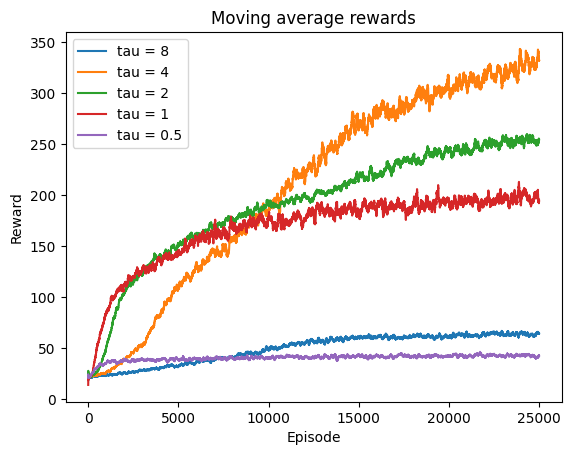

In [13]:
for tau in tau_values:
    plt.plot(range(1, len(rewards[tau])+1), moving_average(rewards[tau], 100), label='tau = ' + str(tau))
plt.title('Moving average rewards')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend()
plt.show()